In [1]:
# Common import

import os

import math
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score, classification_report)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K

from functools import reduce # for union of more than 2 arrays
BatchNormalization
from helper_functions import *

# This is simply an alias for convenience
layers = tf.keras.layers

#Fixing seed for reproducibility
np.random.seed(42)

C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# Loading DataSet
local_data = './DataFiles/Mg22_alphaalpha_digiSim.h5'
hf = h5py.File(local_data, 'r')

# The function load_fata (helper_functions.py) performes the operation mentioned above.
DataList, Labels = load_data(hf)
hf.close() # closing file

Dataset contains 2000 events
Data contains 5 empty events, of indexes: [384, 430, 484, 914, 1204]

Dataset contains 1995 non-empty events:
995 Beam Events, and 1000 Reaction Events



In [3]:
# Create an ordered index list : [0,1,2,...,len(DataList)]
x_idx = np.arange(len(DataList))

# Splitting in train+validation (90% in total), and test (10%)
trainval_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.10)

# Splitting the remaining part (90% of the original DataSet): Training (90%) and Validation (10%)
train_idx, val_idx, not_used3, not_used4 = train_test_split(trainval_idx, trainval_idx, test_size = 0.10)

print("Dataset was divided into:")
print(str(len(train_idx)) + " training events,")
print(str(len(val_idx)) + "  validation events, and")
print(str(len(test_idx)) + "  test events")

Dataset was divided into:
1615 training events,
180  validation events, and
200  test events


In [4]:
# Computing Features through the function calc_features (helper_functions.py)
(MeanXPerEvent, MeanYPerEvent, MeanZPerEvent, SumAPerEvent, 
PadsPerEvent, MeanWeightedXPerEvent, MeanWeightedYPerEvent, 
StDevXPerEvent, StDevYPerEvent, StDevZPerEvent,FracClosePtsPerEvent) = calc_features(DataList)

In [5]:
# Some definition before plotting 

# Splitting train_ind into beam and reaction indexes
train_r_idx = [] # List of indexes of "Reaction" training event
train_b_idx = [] # List of indexes of "Beam" training event

for i in train_idx:
    if Labels[i]>0.5:
        train_r_idx.append(i) # Indexes of "Reaction" training data
    else:
        train_b_idx.append(i) # Indexes of "Beam" training data
        
# Converting into numpy array for later use
train_r_idx = np.array(train_r_idx) 
train_b_idx = np.array(train_b_idx)

# Defining colours for histograms and scatter plot
b_color = 'black'
r_color = 'blue'

#Define legend for 2d (scatter)plots
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Beam', markerfacecolor=b_color, markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Reaction', markerfacecolor=r_color, markersize=15)]

In [6]:
xSimple = np.zeros((len(DataList),5)) # Design Matrix with 5 features

# Filling the matrix
for i in range(len(DataList)):
    xSimple[i][0] = MeanZPerEvent[i]
    xSimple[i][1] = StDevXPerEvent[i]
    xSimple[i][2] = FracClosePtsPerEvent[i]
    xSimple[i][3] = SumAPerEvent[i]
    xSimple[i][4] = PadsPerEvent[i]
# not used 
    #xSimple[i][0] = MeanXPerEvent[i]
    #xSimple[i][1] = MeanYPerEvent[i]
    #xSimple[i][1] = StDevYPerEvent[i]
    #xSimple[i][5] = StDevZPerEvent[i]

# Dividing entries in train, val and test
xSimple_train = xSimple[train_idx][:]
xSimple_val = xSimple[val_idx][:]
xSimple_test = xSimple[test_idx][:]
Labels_train = Labels[train_idx]
Labels_val = Labels[val_idx]
Labels_test = Labels[test_idx]

# Converting to DataFrame for better visualization, and for possible later use
X= pd.DataFrame(xSimple)
print("Design Matrix X:")
X.columns = ['Mean Z','stdev(X)','FCP','Total Q','Pads']
X

Design Matrix X:


,Mean Z,stdev(X),FCP,Total Q,Pads
0,961.083333,0.930198,1.000000,41292.864135,24.0
1,661.897436,5.692321,0.097436,322786.822798,195.0
2,877.083333,0.930198,1.000000,89094.206758,24.0
3,529.016129,0.646942,0.153226,168967.813590,124.0
4,938.916667,0.930198,1.000000,34598.337410,24.0
...,...,...,...,...,...
1990,485.930818,3.872534,0.062893,364154.705449,318.0
1991,817.750000,0.930198,1.000000,117215.746684,24.0
1992,526.930233,0.782013,0.418605,37851.885998,43.0
1993,940.083333,0.930198,1.000000,45542.970478,24.0


In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(xSimple_train)

# Using the standardscaler
xSimple_train_stdsc = scaler.transform(xSimple_train)
xSimple_val_stdsc = scaler.transform(xSimple_val)

# Convolutional Neural Network

### How do we create an image out of an event??
This is how an event looks like: 
```
DataList[0]:
array([(-2.45412970e+00,  1.45075214, 834., 417, 6.73360577e+03, 0),
       (-1.33514404e-05,  2.79990482, 834., 417, 1.25854633e+04, 0),
       (-2.45412970e+00, -1.45075214, 834., 417, 1.70520808e+03, 0),
       (...
       (-7.36236525e+00, -1.45075214, 998., 499, 1.74805170e+01, 0)]
```

We want to convert this in a 2D image, to use for the CNN algorithm. 

The first thought is to use the the (x,y) projection: we will pixel the surface in order to save it as a 2D matrix.
We would like that every pad correspond to a matrix element, or at least that every matrix element is associated to the same number of pads.

Once the 2D matrix is prepared, we need to fill the image with the pixel values: the best choice is to use the charge deposited on that pad as pixel value. We will use 1/0 ("fired/not fired"), since it represents a good check for bugs, and a good way of visualizing the data.

With the images produced we will feed the CNN algorithm, and evaluate the perormances.

### Preparing the data:
We first store teh data in a convenient format.

In [8]:
# Generate arrays to perform math operations
points, xy_values = prepare_images_data(DataList)

###  Get Pad Plane Dimenstion.
We can extract the dimension of the image we want to create, based on the max/min values of the (x,y)-tuple.
We will assume the pad plane is squared.
The information concerning the pad plane will be printed below.

In [9]:
x_max = np.amax(xy_values[:,0])
x_min = np.amin(xy_values[:,0])  
y_max = np.amax(xy_values[:,1])
y_min = np.amin(xy_values[:,1])
x_uniques = np.unique(np.around(xy_values[:,0],3))
y_uniques = np.unique(np.around(xy_values[:,1],3))

print("PAD PLANE Dimensions: ")
print("")
print("X range: ", (round(x_max,2), round(x_min,2)))
print("Y range: ", (round(y_max,2), round(y_min,2)))
print("")

# Show (some) discrete values that x and y can assume...
print("Possible positive values of x: ")
print(x_uniques[x_uniques>0][0:10], " and so on...")
print("Possible positive values of y: ")
print(y_uniques[y_uniques>0][0:10], " and so on...")

PAD PLANE Dimensions: 

X range:  (255.23, -255.23)
Y range:  (252.37, -252.37)

Possible positive values of x: 
[ 2.454  4.908  7.362  9.816 12.271 14.725 17.179 19.633 22.087 24.541]  and so on...
Possible positive values of y: 
[ 1.451  2.8    2.868  5.701  5.837  7.051  9.952 11.301 11.369 14.203]  and so on...


We can see that the (x,y)-tuple assume only discete values (as expected, since we have a discrete number of pads). The positions of the tuple correspond at the center of the corresponding pad.

### Visualizing the Pad Plane: 
In order to genereate a proper matrix, we first need how to set the grid on the (x,y) place. The exercise does not give us the dimension of the single pads, but we can figure it out.
Plotting the superposition of all the events, we can visualize the pad plane structure.

Pad Plane: Superposition of all Events


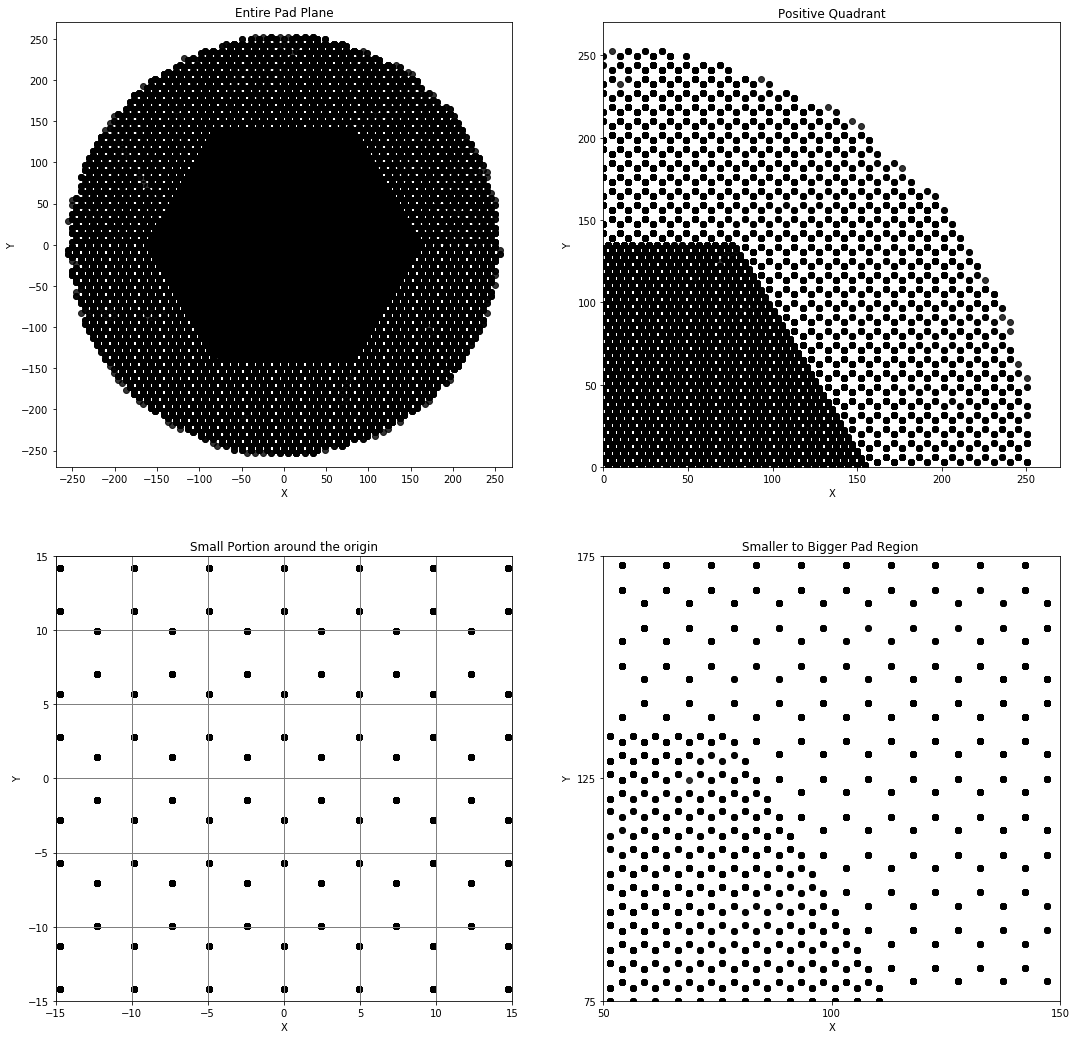

In [10]:
print("Pad Plane: Superposition of all Events")
plot_pad_plane(xy_values)

We deduce different things from thess images:
- The simulated events seems to span all over the pad plane, as should be.
- The singlepad plane shape is triagular, and we can calculate the exact dimension.
- The pad plane does not have the same dimension, but in the most peripheral region, the pads become bigger (but remain triangular).

We can visualize even a single event to see which pads fired:

Plotting Event_1 Fired Pads:


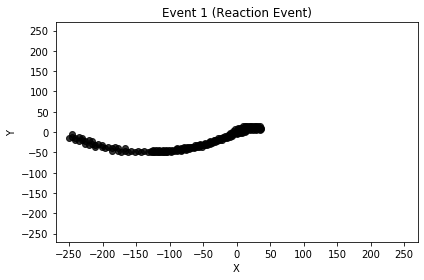

In [11]:
print("Plotting Event_1 Fired Pads:")
fig, ax = plt.subplots( figsize=(6, 4))
xy_event_1 = get_xy_event(points, 1)

ax.set_title("Event 1 (Reaction Event)")
ax.scatter(xy_event_1[:,0],xy_event_1[:,1], c = "black", alpha=0.8)
ax.set_xlabel("X")
ax.set_ylabel("Y")    
ax.set_xticks(np.arange(-250, +251, 50))
ax.set_yticks(np.arange(-250, +251, 50))
ax.set_xlim(-270,+270)
ax.set_ylim(-270,+270)

fig.tight_layout()
plt.show()

### Seting the 2D Matrix:
From the previous plot, in particular the one of the Pad Plane structure close to the origin, we can start thinkin ga good way in order to "pixel/grid" our surface.

We divide the surface in little squared pixels, computing manually the spacing among each pad, both in x, and in y direction. It requires a bit of work, in order to etract the proper values.

Some of these numbers have been obtain looking studying the grid, extracting values based on geometric consideration, and using these value in order to compute the grid spacing with a good precision, that's why some numerical values appear "hard coded". I am aware the cell above looks quite ugly, anyway form the plots that follow it is possible to check that the calculation is correct. 

In [12]:
#Calculate with better precision
x_temp = np.unique(np.around(xy_values[:,0],5))
y_temp = np.unique(np.around(xy_values[:,1],5))


# X - spacing calculation
print("Calculatig X-spacing")
print("--------------------------------------------------")
print("Showing last x values: ", x_temp[-4:])
print("Approximate number of cells: ", x_temp[-1]/2.454) #2.454 is the approximate spacing
nxc = int(round(x_temp[-1]/2.454))
print("Correct number of cells: ", nxc)
x_spc = x_temp[-1]/nxc # this is the spacing calculated more accurately
print("So that the corret spacing is ", x_spc)
x_shift = x_spc/2
print("")
# Y - spacing calculation
print("Calculatig X-spacing")
print("--------------------------------------------------")
print("Last y values: ", y_temp[-4:])
#print(y_temp[-30:-20]) # here you can find the value of 134.57027
print("Approximate number of exagons:", (134.57027+1.4508)/(7.0506+1.4508))
nyex = int(round((134.57027+1.4508)/(7.0506+1.4508)))
print("Correct number of exagons: ", nyex)
y_spc = (134.57+1.4508)/(nyex*4)
print("The corret spacing is ", y_spc)
y_shift = 0

#y_spc = 2.1422616225
#y_shift = 0

Calculatig X-spacing
--------------------------------------------------
Showing last x values:  [245.4118  250.32001 250.32004 255.22827]
Approximate number of cells:  104.005
Correct number of cells:  104
So that the corret spacing is  2.454117980769231

Calculatig X-spacing
--------------------------------------------------
Last y values:  [240.9044  243.87364 249.40572 252.37495]
Approximate number of exagons: 15.999843555179144
Correct number of exagons:  16
The corret spacing is  2.1253249999999997


#### Plotting the Grid
This function will show the grid parameters, and plot the grid. It is possible to check whether it corresponds to the desired result.

Grid Parameters:

X-direction:
----------------------------------
X grid spacing:  2.454117980769231
First x cell limits:  (1.2270589903846154, 3.681176971153846)
Number of pixel on x direction: 105*2 =  210

Y-direction:
----------------------------------
X grid spacing:  2.1253249999999997
First y cell limits:  (0, 2.1253249999999997)
Number of pixel in y direction: 119*2 =  238


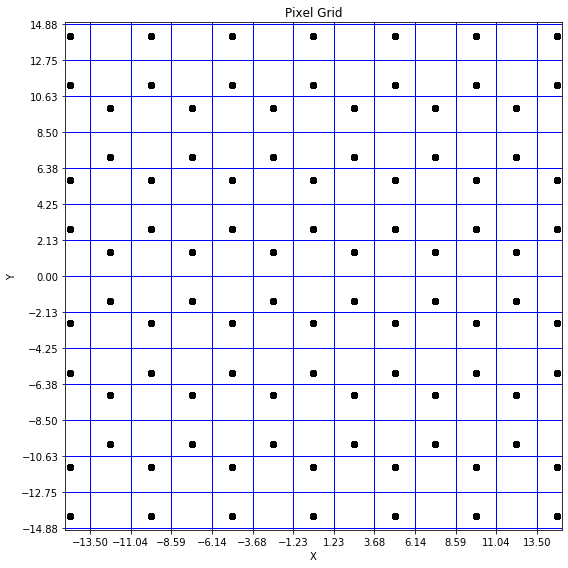

In [13]:
show_grid(xy_values, x_max, y_max, x_spc, y_spc, x_shift, y_shift)

### Improved Grid
We do not like that many pads will have for sure no charge, since they do not contain any points. We try to merge four pads together, and use the new grid as show below. This grid guarantees that each pixel contain the same amount of pad (i.e. 2 pads per pixel).

Grid Parameters:

X-direction:
----------------------------------
X grid spacing:  4.908235961538462
First x cell limits:  (1.2270589903846154, 6.135294951923077)
Number of pixel on x direction: 53*2 =  106

Y-direction:
----------------------------------
X grid spacing:  4.250649999999999
First y cell limits:  (0, 4.250649999999999)
Number of pixel in y direction: -59*2 =  -118


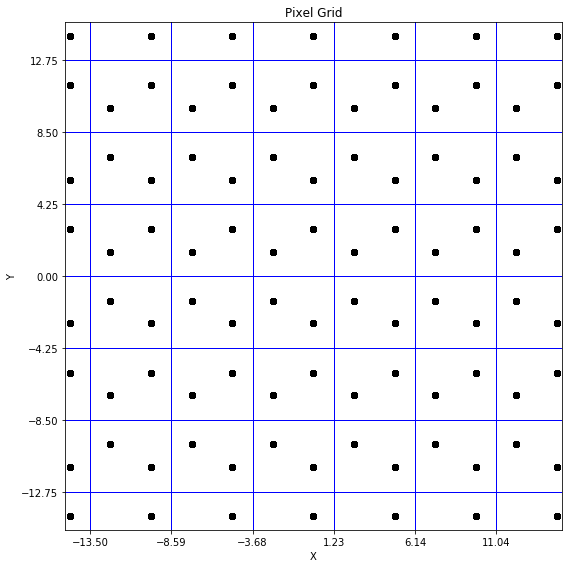

In [14]:
x_grid = x_spc*2
y_grid = y_spc*2
x_shift_grid = x_grid/4
y_shift_grid = 0

show_grid(xy_values, x_max, y_min, x_grid, y_grid, x_shift_grid, y_shift_grid)

### Transalte an event into an image
We will generate two different type of images:
- images: pixel value is equal to charge deposited.
- images_pads: pixel value is the number of time that pixel fired during the event.

The choice that carries more physical meaning is to have the image pixels filled with the respective charge deposited, but also plotting the images of pad "fired/not fired" is pretty interesting.

First, we define the pixel values accordingly, then we assign it to the proper matrix element.


In [15]:
Q = []
pads = []

for i in range(len(points)): # loop on event number
    Q.append([])
    pads.append([])
    for j in range(len(points[i])): # loop on event rows
        Q[i].append(DataList[i][j][4]) 
        pads[i].append(1)

images = generate_images(points, Q, x_max, y_max, x_grid, y_grid, x_shift_grid, y_shift_grid)
images_pads = generate_images(points, pads, x_max, y_max, x_grid, y_grid, x_shift_grid, y_shift_grid)

The images generated have a dimension : (120, 106)
The images generated have a dimension : (120, 106)


### Reducing Images Dimenstion

We want to reduce the dimension to limit the time to run the model. Also, most of the information is contained in the center of the pad plane, so we ""throw away" the most peripher pixels.

In [21]:
# Working with reduced images
images_red = reduce_images_dim(images, 80)
images_pads_red = reduce_images_dim(images_pads, 80)


Images of dimension: (120, 106)  reduced to dimension of  (80, 80)
The external pixels have been removed
Images of dimension: (120, 106)  reduced to dimension of  (80, 80)
The external pixels have been removed


### Merging Pixels
In order to compute faster, we will make the picture more "blurred", converting block of 4 pixels into 1. The image will reduce significatively.

Edit: We decided to not use this step in order to increase accuracy

In [22]:
images_red_merged = merge_pixels(images_red, 2, 2)
images_pads_red_merged = merge_pixels(images_pads_red, 2, 2)

Images of dimension: (80, 80)  reduced to dimension of  (40, 40)
The pixels have been merged in block of  (2, 2)  along the x, and y axes respectively
Images of dimension: (80, 80)  reduced to dimension of  (40, 40)
The pixels have been merged in block of  (2, 2)  along the x, and y axes respectively


### Normalized the images
Last step is to normalize the images, we use the range (0,255) only integer.  

In [40]:
images_processed= normalize_image_data(images_red)
images_pads_processed= normalize_image_data(images_pads_red)

### Visualizing the images obtained
We use this function in order to plot the images obtained after the "pre-processing" phase.
We will plot the two type of images: pixel values = Q, pixel values = fired/not fired.

Printing Images Q


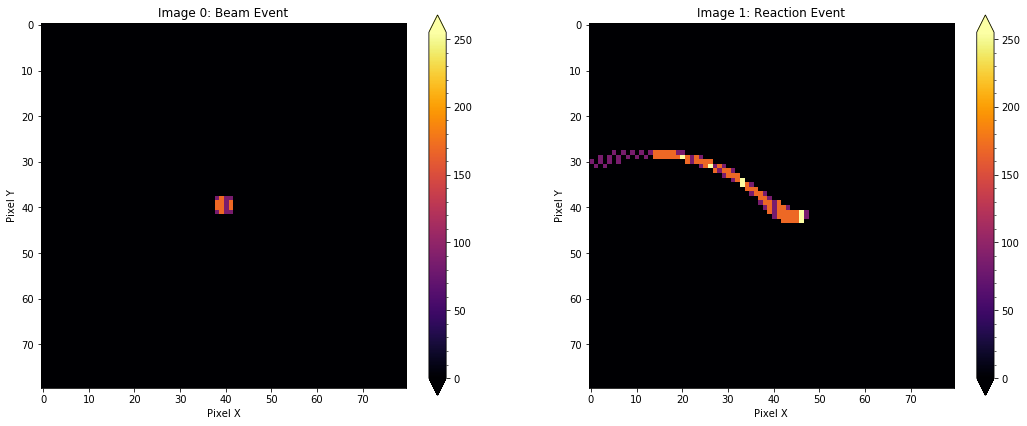

Printing Images Pads


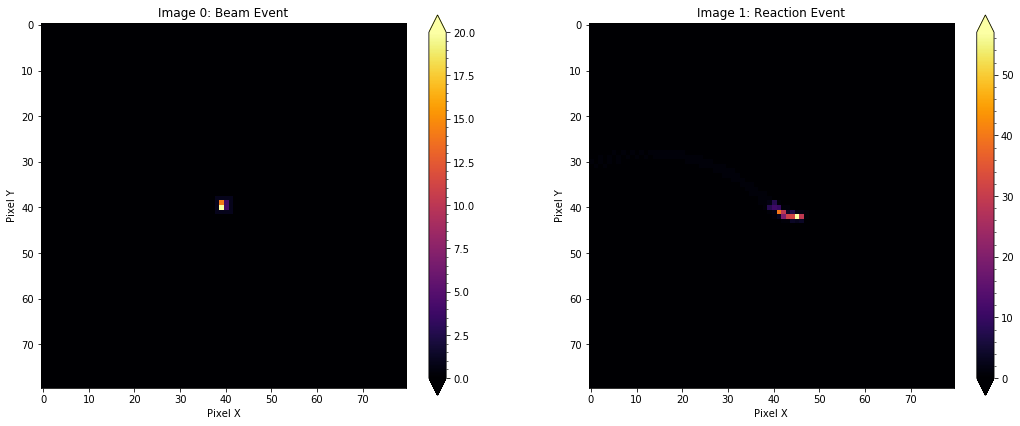

In [41]:
print("Printing Images Q")
plot_images(images_pads_processed, Labels,0, 1)
print("Printing Images Pads")
plot_images(images_processed, Labels,1, 1)
#plot_images(images_ML_pads, Labels)

## Convolutional Network

The images are now ready to be processed  by the CNN algorithms. We just neeed to define train/val images split, using train_idx and val ixd.

In [50]:
from tensorflow.keras.utils import to_categorical

images_ML = np.reshape(images_processed, (images_processed.shape[0], images_processed.shape[1], images_processed.shape[2], 1)) # image, x, y, ch

images_train = images_ML[train_idx]
images_val = images_ML[val_idx]

Labels2_train = to_categorical(Labels_train)
Labels2_val = to_categorical(Labels_val)

### Setting the model
Defining my CNN model.  

In [43]:
my_model = tf.keras.Sequential()

my_model.add(tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(10, 10),
        activation='relu',
        padding='same',
        input_shape=images_ML.shape[1:] # Shape of a single imag
                                )
        )

my_model.add(BatchNormalization())

my_model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
my_model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
my_model.add(tf.keras.layers.Flatten())
my_model.add(tf.keras.layers.Dense(40, activation='relu'))
my_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Once the model is defined, we need to compile it. 
# This is where we specify the loss function, optimizer, and metrics if we want.
my_model.compile(
    tf.keras.optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.9),
    loss='binary_crossentropy', #'sparse_categorical_crossentropy',
    metrics=['accuracy']
)
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 80, 80, 128)       12928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 80, 80, 128)       512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 18, 64)        73792     
_________________________________________________________________
flatten_3 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 40)                829480    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [44]:
history = my_model.fit(images_train,
          Labels_train,
          batch_size=128,
          epochs=5,
          validation_data=(images_val, Labels_val));

Train on 1615 samples, validate on 180 samples
Epoch 1/5


KeyboardInterrupt: 

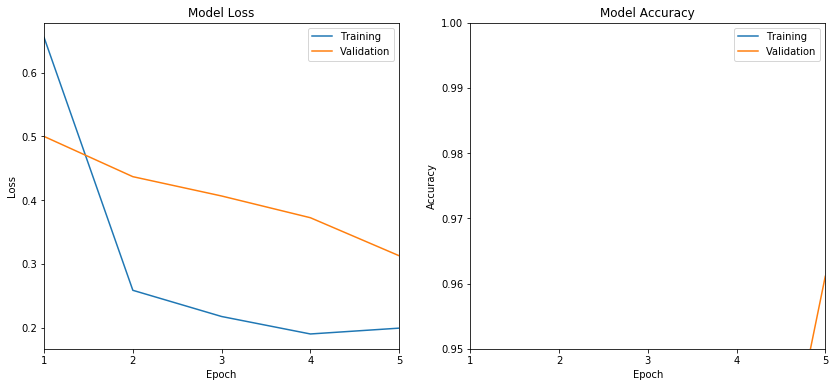

In [33]:
make_nn_plots(history,0.95)

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 94.92%
Precision : 97.48%
Recall    : 92.10%
F1-score  : 0.9471
MCC       : 0.8997


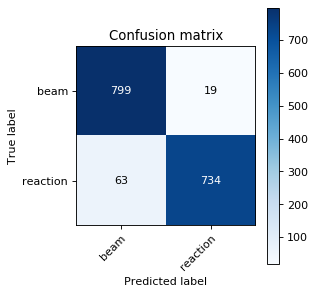


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 96.11%
Precision : 96.70%
Recall    : 95.65%
F1-score  : 0.9617
MCC       : 0.9223


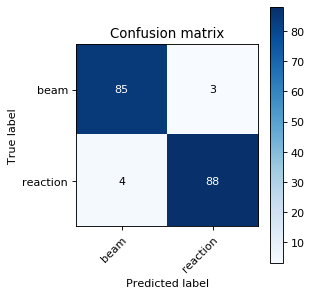

In [34]:
CNN_pred_train_pre = my_model.predict(images_train)
CNN_pred_val_pre = my_model.predict(images_val)
CNN_pred_train = CNN_pred_train_pre > 0.5
CNN_pred_val = CNN_pred_val_pre > 0.5
print_model_performance(Labels_train, CNN_pred_train, "Training")
print_model_performance(Labels_val, CNN_pred_val, "Validation")

### Using VGG model
Importing a pre-trained VGG model.  

In [45]:
images_train_3d = np.expand_dims(images_train,3)
images_train_VGG = np.repeat(images_train,3,3)

images_val_3d = np.expand_dims(images_val,3)
images_val_VGG = np.repeat(images_val,3,3)

In [46]:
model = build_pretrained_vgg_model((images_train_VGG.shape[1],images_train_VGG.shape[2],3), 2)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [47]:
history_VGG = model.fit(images_train_VGG,
          Labels_train,
          batch_size=32,
          epochs=5,
          validation_data=(images_val_VGG, Labels_val));

Train on 1615 samples, validate on 180 samples
Epoch 1/5
1615/1615 [==============================] - 64s 40ms/sample - loss: 0.2571 - acc: 0.9139 - val_loss: 0.1543 - val_acc: 0.9444
Epoch 2/5
1615/1615 [==============================] - 66s 41ms/sample - loss: 0.1697 - acc: 0.9393 - val_loss: 0.1334 - val_acc: 0.9611
Epoch 3/5
1615/1615 [==============================] - 62s 38ms/sample - loss: 0.1381 - acc: 0.9529 - val_loss: 0.2183 - val_acc: 0.9389
Epoch 4/5
1615/1615 [==============================] - 61s 38ms/sample - loss: 0.1504 - acc: 0.9554 - val_loss: 0.1014 - val_acc: 0.9667
Epoch 5/5
1615/1615 [==============================] - 62s 39ms/sample - loss: 0.1251 - acc: 0.9598 - val_loss: 0.1466 - val_acc: 0.9722


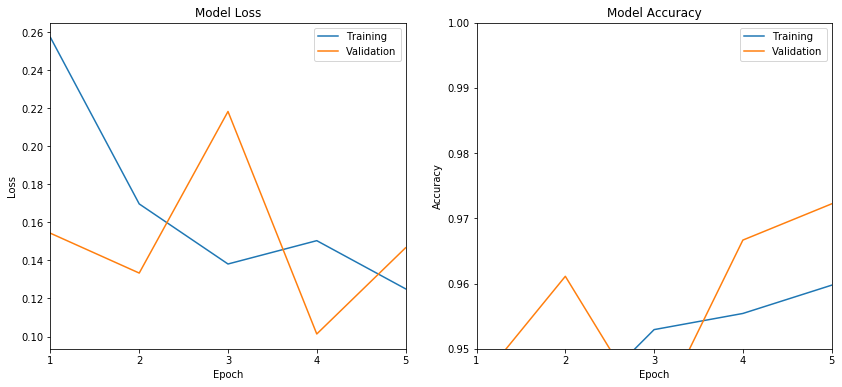

In [48]:
make_nn_plots(history_VGG,0.95)

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 97.59%
Precision : 97.73%
Recall    : 97.37%
F1-score  : 0.9755
MCC       : 0.9517


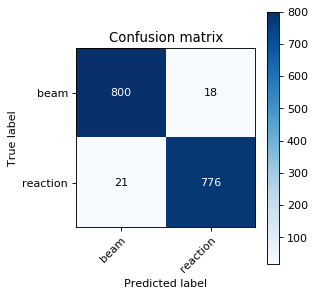


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 97.22%
Precision : 97.80%
Recall    : 96.74%
F1-score  : 0.9727
MCC       : 0.9445


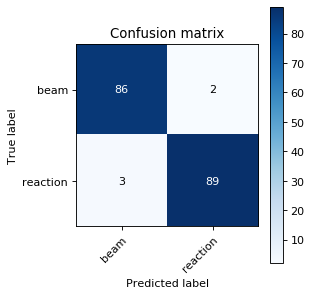

In [49]:
VGG_pred_train_pre = model.predict(images_train_VGG)
VGG_pred_val_pre = model.predict(images_val_VGG)
VGG_pred_train = VGG_pred_train_pre > 0.5
VGG_pred_val = VGG_pred_val_pre > 0.5
print_model_performance(Labels_train, VGG_pred_train, "Training")
print_model_performance(Labels_val, VGG_pred_val, "Validation")